In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Generalized Function to Load Data

In [4]:
def load_data(folder_path, pattern_prefix):
    """
    Load data from Excel files with flexible naming pattern
    
    Args:
        folder_path: Path to directory containing Excel files
        pattern_prefix: The middle part of the filename (e.g., "Location" or "Scenarios")
                       Files should be named like f"SA_{pattern_prefix}_*.xlsx"
    
    Returns:
        Nested dictionary: {name: {sheet: DataFrame}}
    """
    # Verify the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The directory {folder_path} does not exist")
    
    # Create regex pattern to extract names
    pattern = re.compile(fr'SA_{pattern_prefix}_(.*?)\.xlsx')
    
    # Get all names from filenames
    names = []
    for f in os.listdir(folder_path):
        match = pattern.match(f)
        if match:
            names.append(match.group(1))
    
    # Initialize nested dictionary
    data_dict = {name: {} for name in names}
    
    # Read each file and its sheets
    for name in data_dict.keys():
        filename = f"SA_{pattern_prefix}_{name}.xlsx"
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read all sheets from the Excel file
            sheets = pd.read_excel(file_path, sheet_name=None)
            
            # Store each sheet (Fold_1 to Fold_5) in the dictionary
            for sheet_num in range(1, 6):
                sheet_name = f"Fold_{sheet_num}"
                if sheet_name in sheets:
                    data_dict[name][sheet_name] = sheets[sheet_name]
                else:
                    print(f"Warning: Sheet {sheet_name} not found in {filename}")
                    
        except FileNotFoundError:
            print(f"Warning: File {filename} not found in {folder_path}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    return data_dict

## Generalized Function to Stacked Algorithm Performance Plot

In [5]:
def prepare_stacked_data(data, fields):
    stacked_data = []
    
    for field, folds in data.items():
        for algorithm in ['LP', 'SO', 'RO']:
            capex_sum = opex_hvac_sum = opex_c_sum = 0
            count = 0
            
            for fold, df in folds.items():
                alg_df = df[df['Algorithm'] == algorithm]
                if not alg_df.empty:
                    capex_sum += alg_df['Training Capital Cost'].mean()
                    opex_hvac_sum += alg_df['Testing HVAC Cost'].mean()
                    opex_c_sum += alg_df['Testing Critical Load Cost'].mean()
                    count += 1
            
            if count > 0:
                stacked_data.append({
                    fields: field,
                    'Algorithm': algorithm,
                    'CaPEX': capex_sum / count,
                    'OPEX HVAC': opex_hvac_sum / count,
                    'OPEX C': opex_c_sum / count,
                    'Total': (capex_sum + opex_hvac_sum + opex_c_sum) / count
                })
    
    return pd.DataFrame(stacked_data)

def plot_grouped_stacked_bars(data, SA_name, plot_name):
    # Prepare data
    stacked_df = prepare_stacked_data(data, SA_name)  # From previous step
    locations = stacked_df[SA_name].unique()
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # CaPEX, OPEX HVAC, OPEX C

    # Create subplots with independent y-axes
    fig, axes = plt.subplots(1, len(locations), figsize=(22, 8), 
                sharex=False, sharey=False)
    plt.subplots_adjust(wspace=0.4)  # Space between subplots

    # Plot settings
    bar_width = 0.6  # Controls spacing between bars
    x_pos = np.arange(len(algorithms))  # Positions for LP, SO, RO

    for idx, (ax, loc) in enumerate(zip(axes, locations)):
        # Filter location data
        loc_df = stacked_df[stacked_df[SA_name] == loc]
        
        # Initialize bottom values
        bottom = np.zeros(len(algorithms))
        
        # Plot stacked components
        for i, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [loc_df[loc_df['Algorithm'] == alg][category].values[0] 
                     for alg in algorithms]
            bars = ax.bar(x_pos, values, bar_width, 
                         bottom=bottom, color=colors[i],
                         edgecolor='white', linewidth=0.5)
            bottom += np.array(values)
        
        # Customize subplot
        ax.set_title(loc, pad=15, fontsize=12)
        ax.set_ylabel('Cost ($)', fontsize=10)
        ax.set_ylim(0, max(bottom)*1.15)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Add algorithm labels above bars
        for j, alg in enumerate(algorithms):
            total_height = bottom[j]
            ax.text(x_pos[j], total_height*1.02, alg, 
                   ha='center', va='bottom', fontsize=10,
                   fontweight='bold', color='#333333')
        
        # Remove x-axis ticks
        ax.set_xticks([])
        
        # Add legend only once
        if idx == 0:
            ax.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'],
                     loc='upper left', fontsize=10)

    plt.suptitle(f'Testing Stage Performance of Algorithms with different {plot_name}', 
                y=1.02, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## Generalized Function to do Capacity Box Plot (Unused)

In [6]:
def capacity_box_plot(location_data, SA_name, plot_name):
    """
    Plot algorithm performance across different categories with dynamic SA name
    
    Args:
        location_data: Nested dictionary {category: {fold: DataFrame}}
        SA_name: String for the sensitivity analysis dimension (e.g., "Locations", "Scenarios")
    """
    # First, restructure the data for plotting
    def prepare_plotting_data(data_dict):
        plot_data = []
        for category, folds in data_dict.items():
            for fold_num, df in folds.items():
                temp_df = df.copy()
                temp_df['Category'] = category
                temp_df['Fold'] = fold_num
                plot_data.append(temp_df)
        return pd.concat(plot_data, ignore_index=True)

    # Prepare the data
    plot_df = prepare_plotting_data(location_data)
    
    # Get unique categories and maintain consistent order
    categories = sorted(plot_df['Category'].unique())
    
    # Create the figure and subplots
    plt.figure(figsize=(18, 12))
    plt.suptitle(f'Capacity Sizings across {plot_name} and Folds', fontsize=16, y=1.02)

    # 1. PV Size subplot
    plt.subplot(2, 2, 1)
    sns.boxplot(x='Category', y='PV_Size', hue='Algorithm', data=plot_df,
                order=categories,
                hue_order=['LP', 'SO', 'RO'])
    plt.title('PV Size Distribution')
    plt.xlabel(SA_name)
    plt.ylabel('PV Size')
    plt.legend(title='Algorithm')

    # 2. Battery Size subplot
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Category', y='Battery_Size', hue='Algorithm', data=plot_df,
                order=categories,
                hue_order=['LP', 'SO', 'RO'])
    plt.title('Battery Size Distribution')
    plt.xlabel(SA_name)
    plt.ylabel('Battery Size')
    plt.legend(title='Algorithm')

    # 3. PCM Heating Size subplot
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Category', y='PCM_Heating_Size', hue='Algorithm', data=plot_df,
                order=categories,
                hue_order=['LP', 'SO', 'RO'])
    plt.title('PCM Heating Size Distribution')
    plt.xlabel(SA_name)
    plt.ylabel('PCM Heating Size')
    plt.legend(title='Algorithm')

    # 4. PCM Cooling Size subplot
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Category', y='PCM_Cooling_Size', hue='Algorithm', data=plot_df,
                order=categories,
                hue_order=['LP', 'SO', 'RO'])
    plt.title('PCM Cooling Size Distribution')
    plt.xlabel(SA_name)
    plt.ylabel('PCM Cooling Size')
    plt.legend(title='Algorithm')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## Generalized Function to do Capacity Bar Plot

In [72]:
def scenario_capacity_barplot(location_data, SA_name, plot_name, special_scenarios):
    """
    Plot average capacities with Alaska and Minnesota on left (individual y-axis),
    and other scenarios with shared y-axis range.
    """
    # Prepare data - average across folds
    scenario_avgs = {}
    for scenario, folds in location_data.items():
        all_folds = pd.concat(folds.values())
        scenario_avgs[scenario] = all_folds.groupby('Algorithm')[
            ['PV_Size', 'Battery_Size', 'PCM_Heating_Size', 'PCM_Cooling_Size']
        ].mean().reset_index()
    
    other_scenarios = [s for s in sorted(scenario_avgs.keys()) if s not in special_scenarios]
    
    all_scenarios = special_scenarios + other_scenarios
    n_scenarios = len(all_scenarios)
    
    # Create figure with dynamic layout
    fig_width = min(6 * n_scenarios, 24)  # Cap width at 24 inches
    fig = plt.figure(figsize=(fig_width, 6))
    
    # Create grid spec with dynamic columns
    gs = fig.add_gridspec(1, n_scenarios, width_ratios=[1]*n_scenarios, wspace=0.3)
    
    # Define appliance properties
    appliances = {
        'PV_Size': {'color': '#FFD700', 'label': 'PV'},
        'Battery_Size': {'color': '#32CD32', 'label': 'Battery'},
        'PCM_Heating_Size': {'color': '#FF6347', 'label': 'PCM Heat'},
        'PCM_Cooling_Size': {'color': '#1E90FF', 'label': 'PCM Cool'}
    }
    
    # First plot Alaska and Minnesota with individual y-axis
    for i, scenario in enumerate(special_scenarios):
        ax = fig.add_subplot(gs[0, i])
        data = scenario_avgs[scenario]
        
        # Plot each algorithm's appliances
        for j, algorithm in enumerate(['LP', 'SO', 'RO']):
            alg_data = data[data['Algorithm'] == algorithm]
            x_pos = j
            offset = 0
            
            for k, appliance in enumerate(appliances.keys()):
                ax.bar(x_pos + offset, alg_data[appliance].values[0], 0.2,
                      color=appliances[appliance]['color'],
                      label=appliances[appliance]['label'] if j == 0 else "")
                offset += 0.2
        
        ax.set_title(scenario)
        ax.set_xticks([0.3, 1.3, 2.3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_xlabel('Algorithm')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_ylabel('Average Capacity')
    
    # Then plot other scenarios with shared y-axis range
    if other_scenarios:
        # Calculate global y-axis range for other scenarios
        other_data = pd.concat([scenario_avgs[s] for s in other_scenarios])
        y_min = other_data[list(appliances.keys())].min().min() * 0.9
        y_max = other_data[list(appliances.keys())].max().max() * 1.1
        
        for i, scenario in enumerate(other_scenarios, start=len(special_scenarios)):
            ax = fig.add_subplot(gs[0, i])
            data = scenario_avgs[scenario]
            
            for j, algorithm in enumerate(['LP', 'SO', 'RO']):
                alg_data = data[data['Algorithm'] == algorithm]
                x_pos = j
                offset = 0
                
                for k, appliance in enumerate(appliances.keys()):
                    ax.bar(x_pos + offset, alg_data[appliance].values[0], 0.2,
                          color=appliances[appliance]['color'],
                          label=appliances[appliance]['label'] if j == 0 else "")
                    offset += 0.2
            
            ax.set_title(scenario)
            ax.set_xticks([0.3, 1.3, 2.3])
            ax.set_xticklabels(['LP', 'SO', 'RO'])
            ax.set_xlabel('Algorithm')
            ax.grid(axis='y', linestyle='--', alpha=0.3)
            ax.set_ylim(y_min, y_max)
            
            # Only show y-label for first of these subplots
            if i == len(special_scenarios):
                ax.set_ylabel('Average Capacity')
    
    # Create unified legend
    handles = [plt.Rectangle((0,0),1,1, color=props['color']) 
              for props in appliances.values()]
    fig.legend(handles, appliances.keys(), 
              title='Component', bbox_to_anchor=(1, 0.5), loc='center right',
              fontsize=10)
    
    fig.suptitle(f'Average Capacities by Scenario: {plot_name}', y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()



## Locations

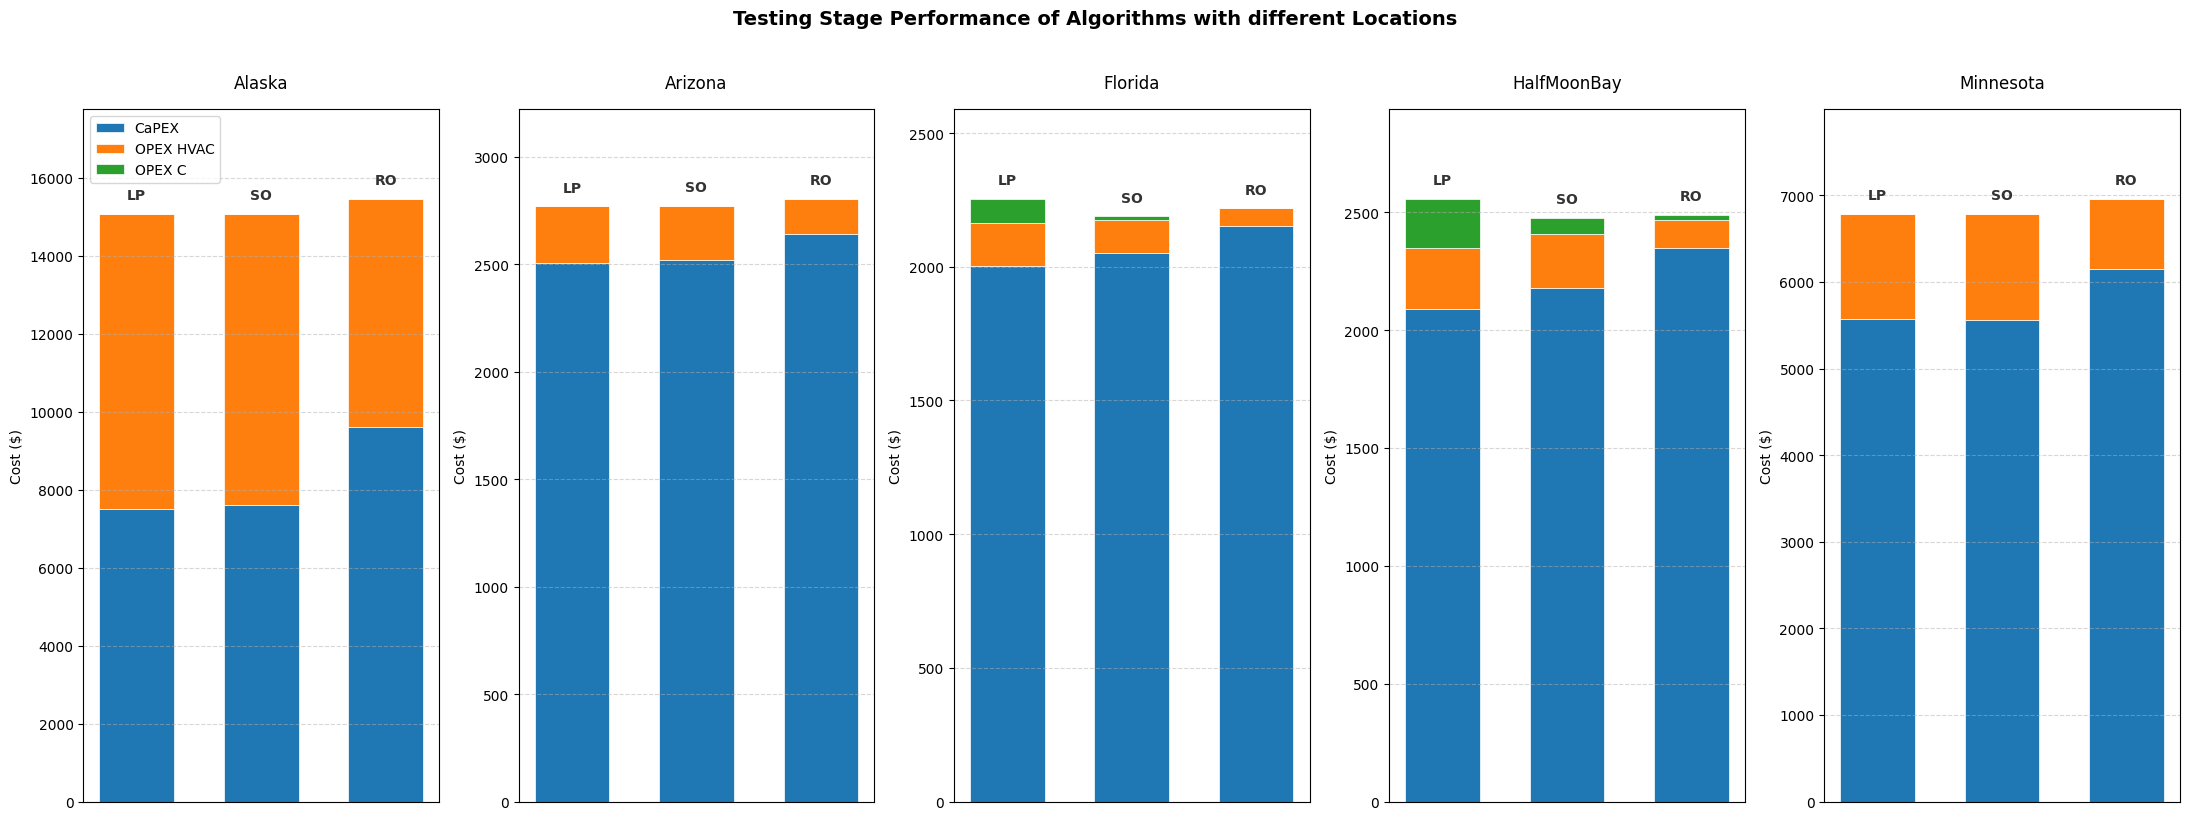

C:\Users\Fred\AppData\Local\Temp\ipykernel_92028\1830020215.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


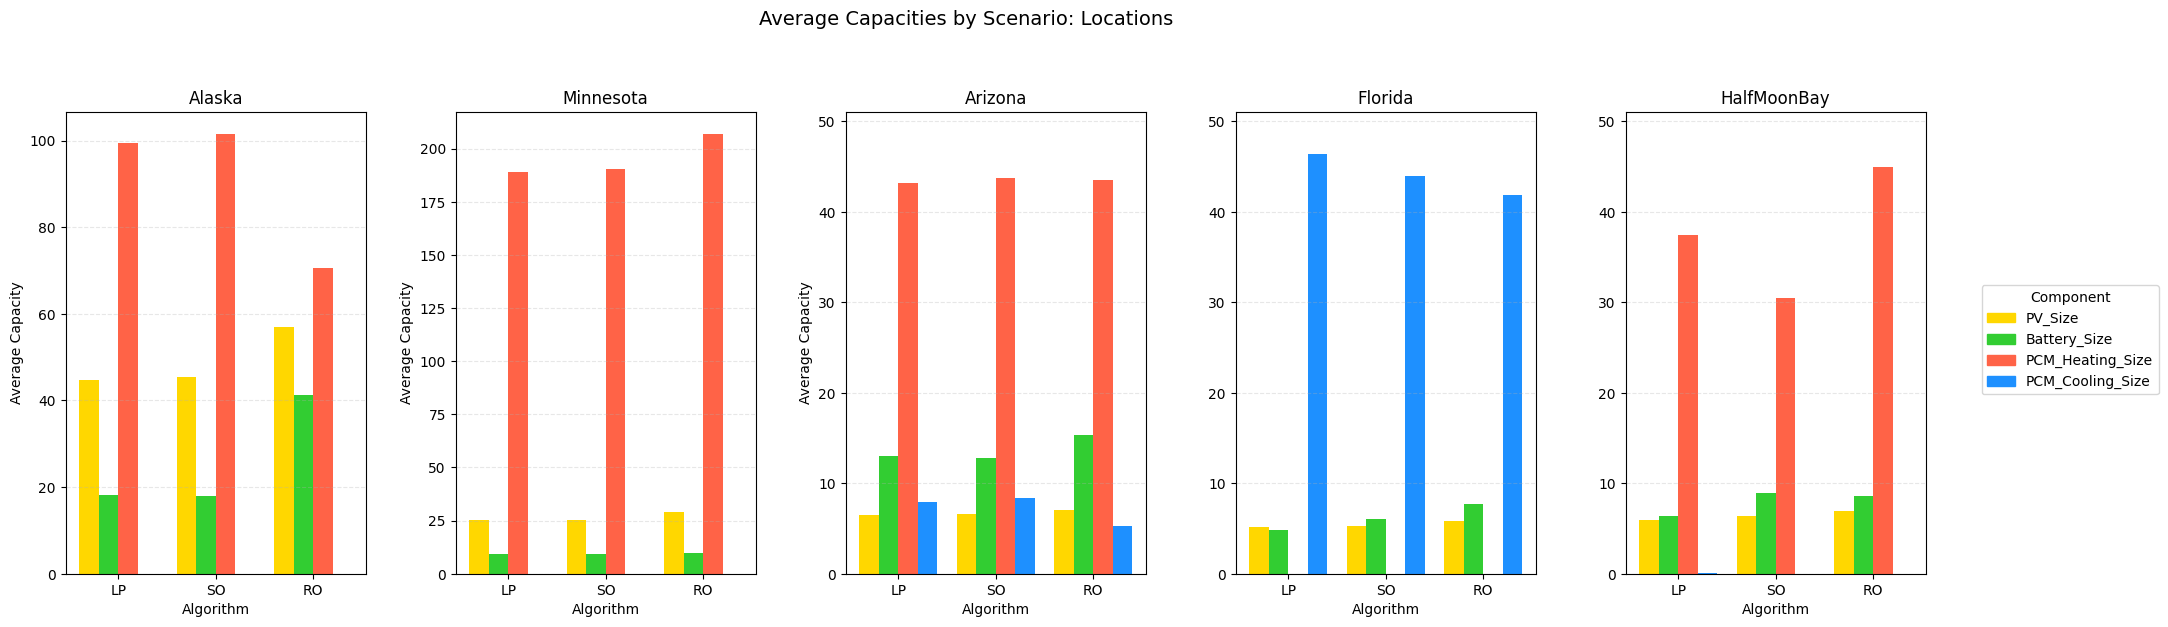

In [41]:
SA_name = 'Locations'

# Example usage for Locations:
location_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars(location_data, SA_name, "Locations")

# Old capacity box plot unused
# capacity_box_plot(location_data, SA_name, "Locations") 

# capacity bar plot
special_scenarios = ['Alaska', 'Minnesota']
scenario_capacity_barplot(location_data, SA_name, "Locations", special_scenarios)

## Scenarios

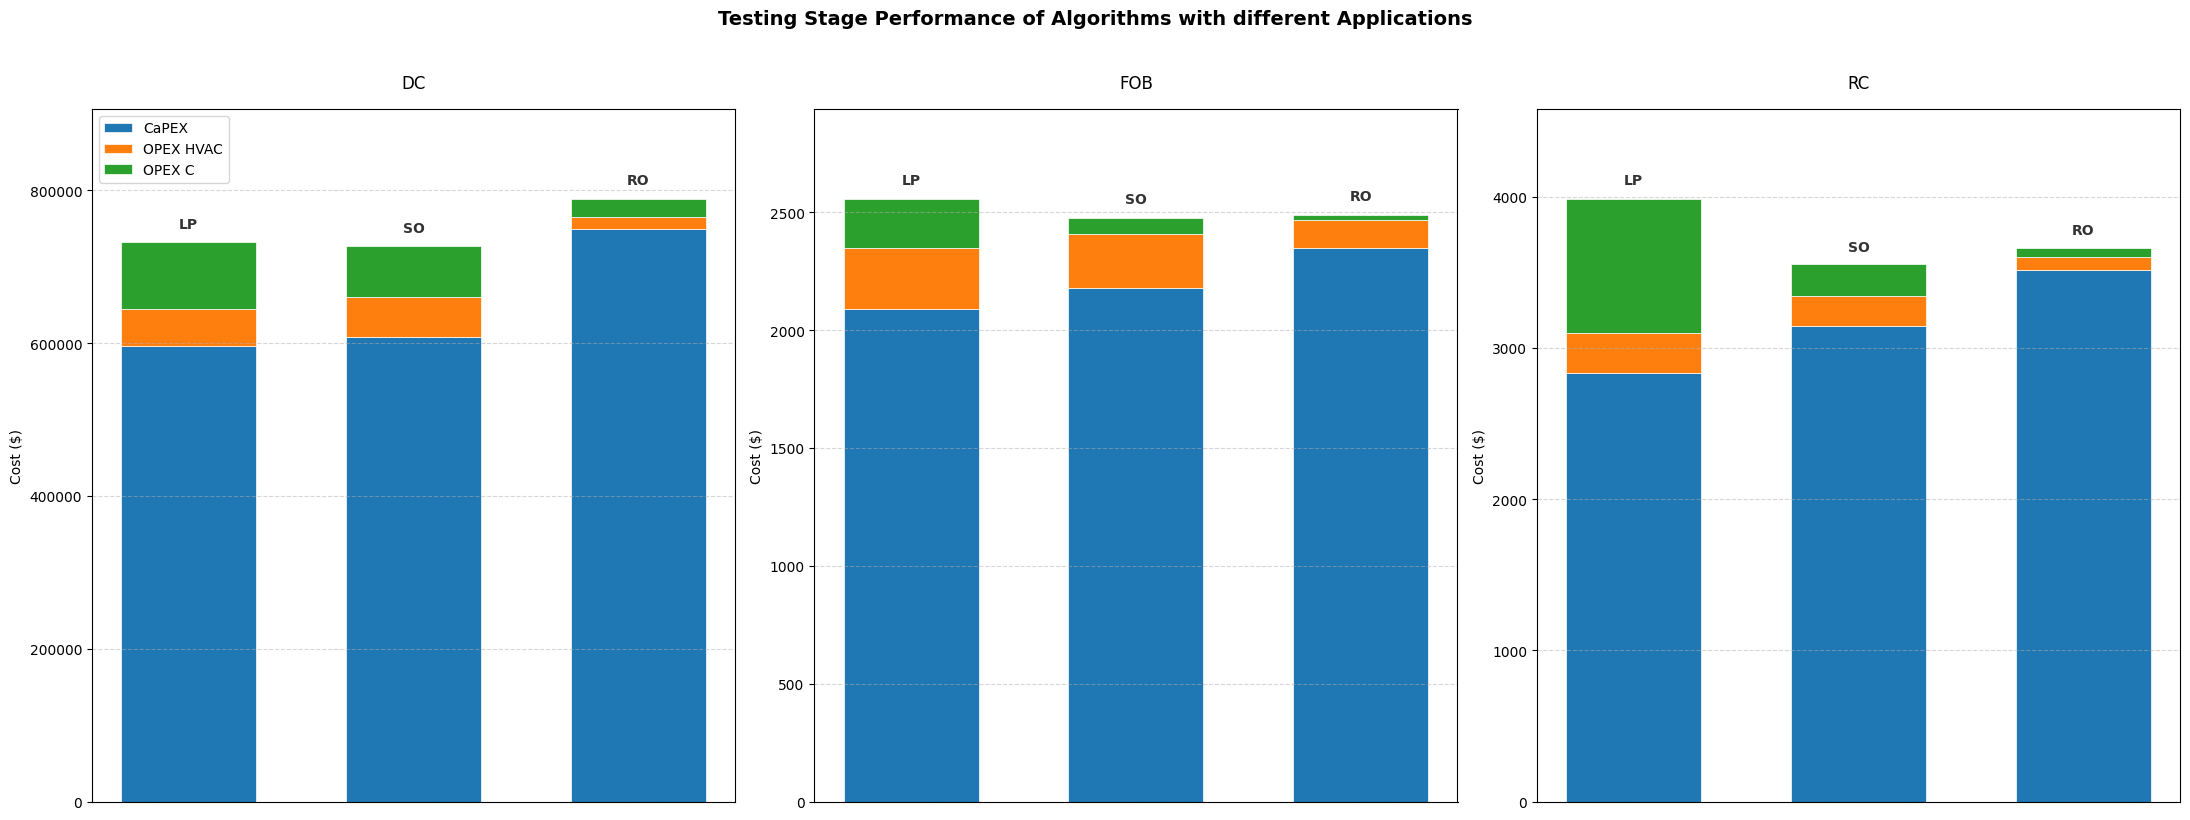

C:\Users\Fred\AppData\Local\Temp\ipykernel_92028\1830020215.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


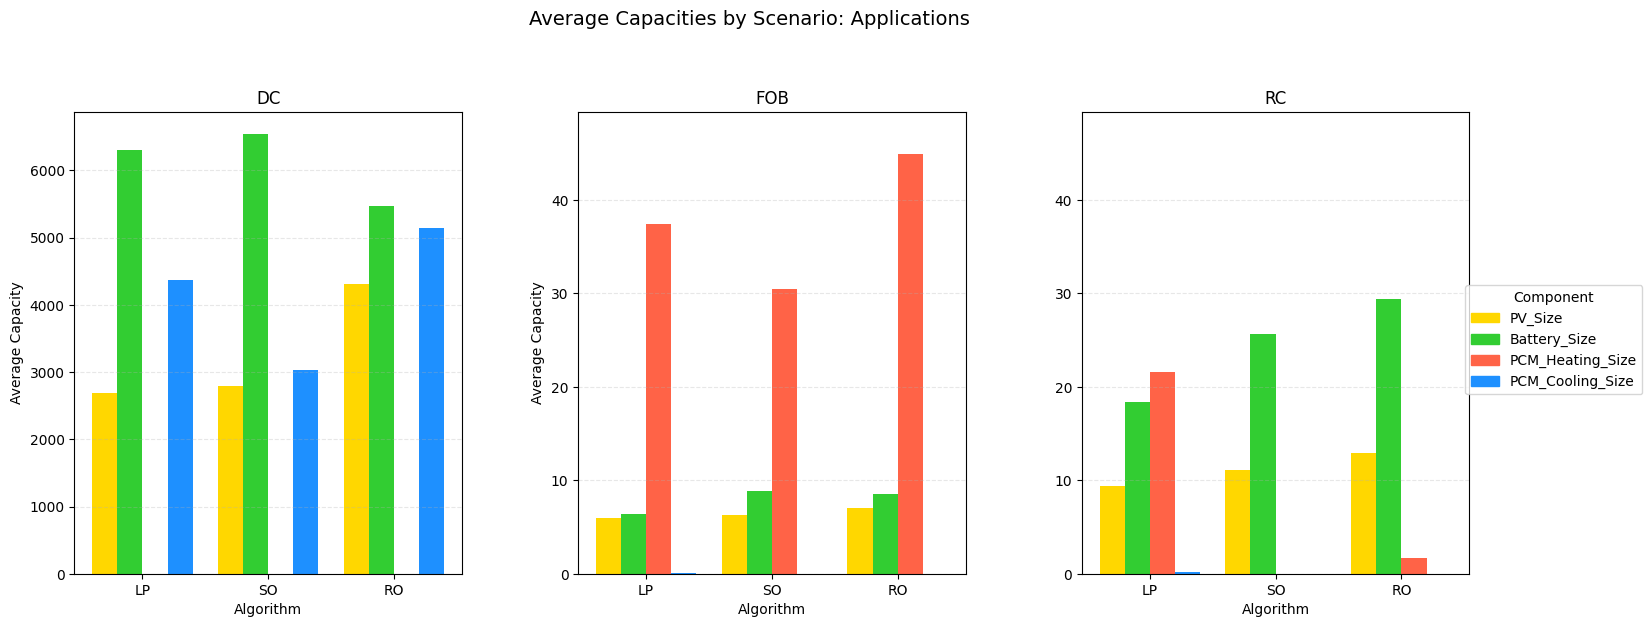

In [18]:
SA_name = 'Scenarios'

# Example usage for Locations:
scenario_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars(scenario_data, SA_name, "Applications")

# Old capacity box plot unused
# capacity_box_plot(scenario_data, SA_name, "Applications")

# capacity bar plot

special_scenarios = ['DC']
scenario_capacity_barplot(scenario_data, SA_name, "Applications", special_scenarios)

## Capacity Costs

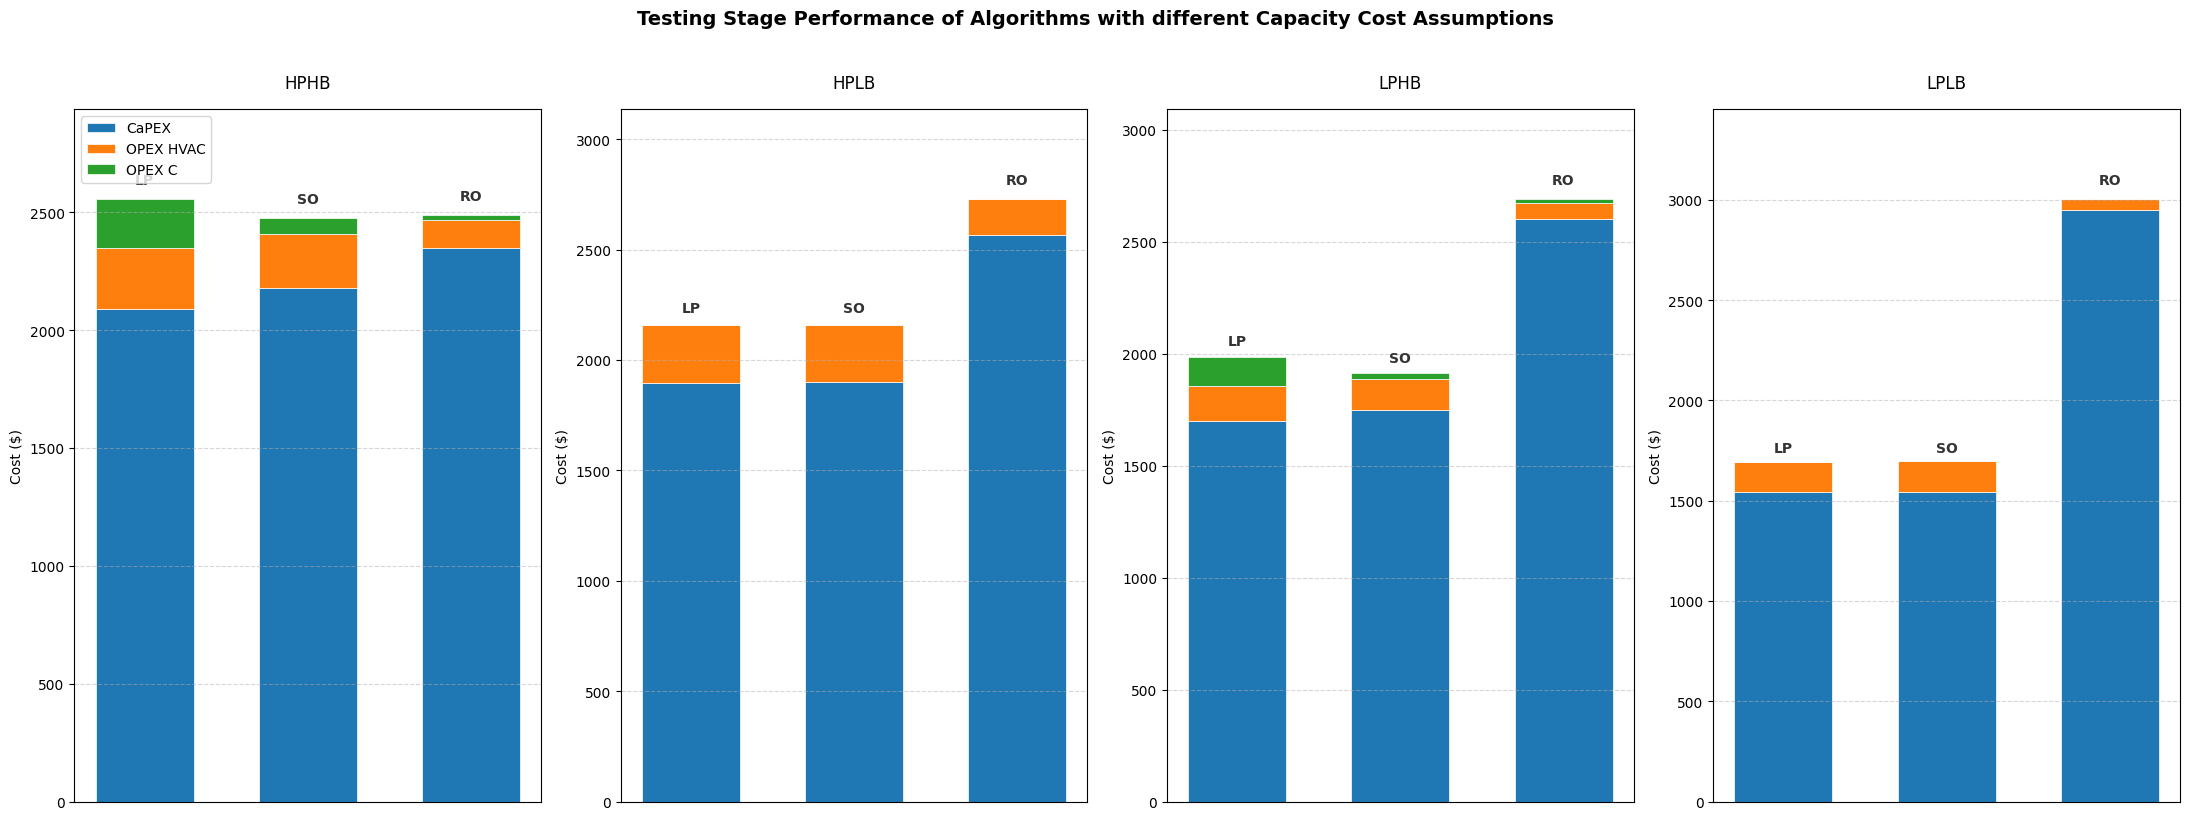

C:\Users\Fred\AppData\Local\Temp\ipykernel_92028\1830020215.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


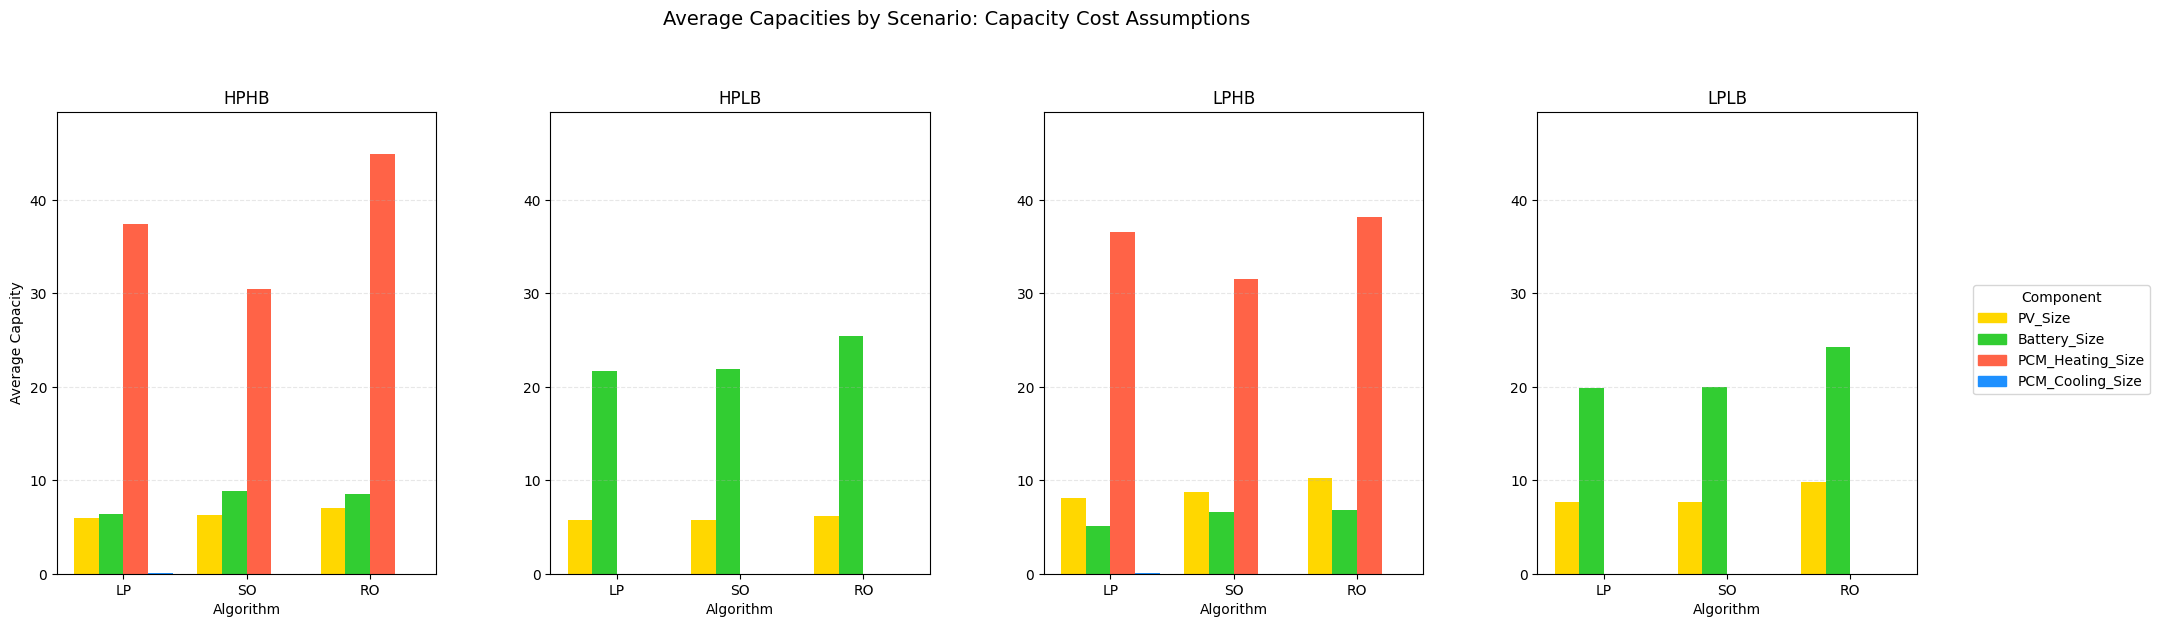

In [19]:
SA_name = 'Capacity_Costs'

# Example usage for Locations:
cap_cost_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars(cap_cost_data, SA_name, "Capacity Cost Assumptions")

# Old capacity box plot unused
# capacity_box_plot(cap_cost_data, SA_name, "Capacity Cost Assumptions")

# capacity bar plot

special_scenarios = []
scenario_capacity_barplot(cap_cost_data, SA_name, "Capacity Cost Assumptions", special_scenarios)

C:\Users\Fred\AppData\Local\Temp\ipykernel_67360\305444061.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


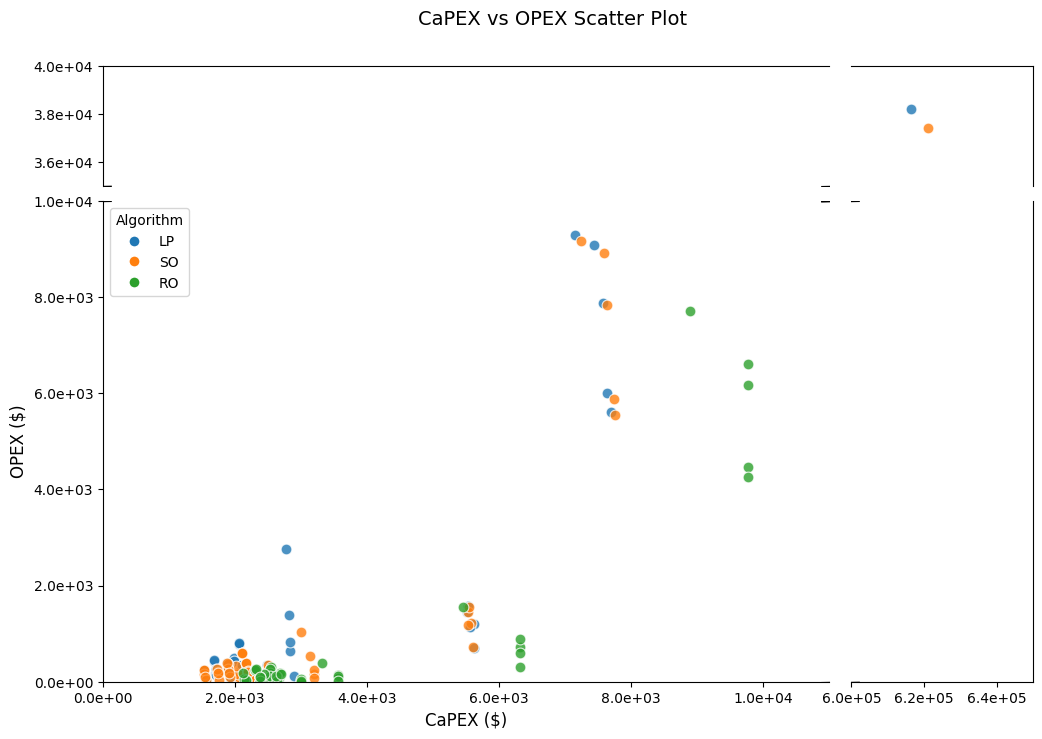

In [97]:
from matplotlib.patches import Rectangle

def prepare_scatter_data(data_dict, category_name):
    """Convert nested dictionary to DataFrame with category label"""
    scatter_data = []
    
    for sub_category, folds in data_dict.items():
        for fold_num, df in folds.items():
            for _, row in df.iterrows():
                scatter_data.append({
                    'Category': category_name,
                    'SubCategory': sub_category,
                    'Fold': fold_num,
                    'Algorithm': row['Algorithm'],
                    'CaPEX': row['Training Capital Cost'],
                    'OPEX': row['Testing HVAC Cost'] + row['Testing Critical Load Cost']
                })
    return pd.DataFrame(scatter_data)

def create_dual_axis_break_plot(all_data):
    # Create figure with custom gridspec
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                        wspace=0.05, hspace=0.05)

    # Create axes
    ax_main = fig.add_subplot(gs[1, 0])  # Main plot area
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)  # High OPEX
    ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)  # High CaPEX
    ax_corner = fig.add_subplot(gs[0, 1])  # High-High quadrant

    # Define colors and style
    colors = {'LP': '#1f77b4', 'SO': '#ff7f0e', 'RO': '#2ca02c'}
    marker_size = 60
    alpha = 0.8

    # Plot data in all relevant areas
    for algorithm, color in colors.items():
        alg_data = all_data[all_data['Algorithm'] == algorithm]
        
        # Main plot (low CaPEX, low OPEX)
        ax_main.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                       c=color, s=marker_size, alpha=alpha, label=algorithm,
                       edgecolor='w', linewidth=0.8)
        
        # High CaPEX area
        ax_right.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                        c=color, s=marker_size, alpha=alpha,
                        edgecolor='w', linewidth=0.8)
        
        # High OPEX area
        ax_top.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                      c=color, s=marker_size, alpha=alpha,
                      edgecolor='w', linewidth=0.8)
        
        # High-High area
        ax_corner.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                         c=color, s=marker_size, alpha=alpha,
                         edgecolor='w', linewidth=0.8)

    # Set axis limits (adjust these based on your data)
    main_xlim = (0, 1.1e4)    # Main CaPEX range
    high_xlim = (6e5, 6.5e5)    # High CaPEX range
    main_ylim = (0, 1e4)      # Main OPEX range
    high_ylim = (3.5e4, 4e4)  # High OPEX range

    ax_main.set_xlim(main_xlim)
    ax_main.set_ylim(main_ylim)
    ax_right.set_xlim(high_xlim)
    ax_right.set_ylim(main_ylim)
    ax_top.set_xlim(main_xlim)
    ax_top.set_ylim(high_ylim)
    ax_corner.set_xlim(high_xlim)
    ax_corner.set_ylim(high_ylim)

    # Hide spines and ticks between plots
    ax_main.spines[['right', 'top']].set_visible(False)
    ax_top.spines[['right', 'bottom']].set_visible(False)
    ax_right.spines[['left', 'top']].set_visible(False)
    ax_corner.spines[['left', 'bottom']].set_visible(False)
    ax_top.tick_params(bottom=False, labelbottom=False)
    ax_right.tick_params(left=False, labelleft=False)
    ax_corner.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Add break markers
    d = 0.02  # Break marker size
    kwargs = dict(marker=[(-1,-d), (1,d)], markersize=12,
                 linestyle="none", color='k', mec='k', mew=1)
    
    # X-axis break
    ax_main.plot([1,1], [0,1], transform=ax_main.transAxes, **kwargs)
    ax_right.plot([0,0], [0,1], transform=ax_right.transAxes, **kwargs)
    
    # Y-axis break
    ax_main.plot([0,1], [1,1], transform=ax_main.transAxes, **kwargs)
    ax_top.plot([0,1], [0,0], transform=ax_top.transAxes, **kwargs)

    # Formatting
    ax_main.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_main.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_top.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_top.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_right.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_right.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))

    # Labels
    ax_main.set_xlabel('CaPEX ($)', fontsize=12)
    ax_main.set_ylabel('OPEX ($)', fontsize=12)
    
    # Legend
    handles = [plt.Line2D([0], [0], marker='o', color='w',
              markersize=8, markerfacecolor=color)
              for color in colors.values()]
    ax_main.legend(handles, colors.keys(), title='Algorithm',
                  loc='upper left', fontsize=10)

    plt.suptitle('CaPEX vs OPEX Scatter Plot', y=0.95, fontsize=14)
    plt.tight_layout()
    plt.show()

# Prepare data (using your existing prepare_scatter_data function)
all_data = pd.concat([
    prepare_scatter_data(location_data, 'Locations'),
    prepare_scatter_data(cap_cost_data, 'Capacity Costs'),
    prepare_scatter_data(scenario_data, 'Scenarios')
])

# Create the plot
create_dual_axis_break_plot(all_data)

## Load Yearly Data

In [57]:
def load_yearly_data_nested(folder_name, file_name):
    """
    Load location data into nested dictionary structure:
    location_data_yr[location][year][variable] = value
    
    Args:
        folder_name: Name of the folder containing the file
        file_name: Name of the Excel file
        
    Returns:
        Nested dictionary {location: {year: {variable: value}}}
    """
    file_path = os.path.join(folder_name, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    try:
        all_sheets = pd.read_excel(file_path, sheet_name=None)
    except Exception as e:
        raise ValueError(f"Error reading Excel file: {str(e)}")
    
    location_data_yr = {}
    
    for sheet_name, df in all_sheets.items():
        # Initialize location dictionary
        location_data_yr[sheet_name] = {}
        
        # Convert Year column to integer
        df['Year'] = df['Year'].astype(int)
        
        # Iterate through each row (year) in the sheet
        for _, row in df.iterrows():
            year = row['Year']
            location_data_yr[sheet_name][year] = {
                'var PV': row['var PV'],
                'var E_Load': row['var E_Load'],
                'var Cooling_Load': row['var Cooling_Load'],
                'var Heating_Load': row['var Heating_Load'],
                'CV PV': row['CV PV'],
                'CV E_Load': row['CV E_Load'],
                'CV Cooling_Load': row['CV Cooling_Load'],
                'CV Heating_Load': row['CV Heating_Load'],
                'Total pv (kWh/kW Capacity)': row['Total pv (kWh/kW Capacity)'],
                'Total E_Load (kWh)': row['Total E_Load (kWh)'],
                'Total Cooling_Load (kWh T)': row['Total Cooling_Load (kWh T)'],
                'Total Heating_Load (kWh T)': row['Total Heating_Load (kWh T)']
            }
    
    return location_data_yr

In [ ]:
location_data_yr = load_yearly_data_nested("Yearly_Results", "locations_result.xlsx")
scenario_data_yr = load_yearly_data_nested("Yearly_Results", "scenarios_result.xlsx")

fold = 5
weather_year_list = list(range(1998, 2023))  # 1998-2022 (25 years total)
algorithms = ["LP", "SO", "RO"]

{'HalfMoonBay': {np.float64(1998.0): {'var PV': np.float64(3.809298751430293), 'var E_Load': np.float64(4.817145777480054), 'var Cooling_Load': np.float64(12.73156524424821), 'var Heating_Load': np.float64(179.7815706067889), 'CV PV': np.float64(0.5205256055405633), 'CV E_Load': np.float64(0.9160548728493352), 'CV Cooling_Load': np.float64(1.283857874413099), 'CV Heating_Load': np.float64(0.6259375189983354), 'Total pv (kWh/kW Capacity)': np.float64(1368.589751697369), 'Total E_Load (kWh)': np.float64(874.5129999999999), 'Total Cooling_Load (kWh T)': np.float64(1014.417692849875), 'Total Heating_Load (kWh T)': np.float64(7818.698481069239)}, np.float64(1999.0): {'var PV': np.float64(3.307869306252719), 'var E_Load': np.float64(5.183040375884389), 'var Cooling_Load': np.float64(11.86268113776409), 'var Heating_Load': np.float64(170.1114502961771), 'CV PV': np.float64(0.4388030925095855), 'CV E_Load': np.float64(0.9472276300831177), 'CV Cooling_Load': np.float64(1.33563970283364), 'CV He

## Calculate cost per energy served for Locations Sensivity Run

In [ ]:
# Initialize the dictionary properly
cost_per_energy_served_loc = {}

for loc in location_data_yr.keys():  # Added parentheses for .keys() method
    # Initialize location in dictionary
    cost_per_energy_served_loc[loc] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_loc[loc][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = location_data[loc][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([location_data_yr[loc][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                location_data_yr[loc][yr]["Total Cooling_Load (kWh T)"] + 
                location_data_yr[loc][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            denominator = (
                (total_e_load/5 - critical_load_cost/300) + 
                (total_thermal_load/5 - hvac_cost/3)
            )
            
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_loc[loc][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_loc[loc][k][algo] = numerator / denominator

## Calculate cost per energy served for Capacity Cost Assumption Sensivity Run

In [53]:
# Initialize the dictionary properly
cost_per_energy_served_cap = {}

caps = ["HPHB", "HPLB", "LPHB", "LPLB"]

for cap in caps: 
    # Initialize location in dictionary
    cost_per_energy_served_cap[cap] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_cap[cap][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = cap_cost_data[cap][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([location_data_yr["HalfMoonBay"][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                location_data_yr["HalfMoonBay"][yr]["Total Cooling_Load (kWh T)"] + 
                location_data_yr["HalfMoonBay"][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            denominator = (
                (total_e_load/5 - critical_load_cost/300) + 
                (total_thermal_load/5 - hvac_cost/3)
            )
            
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_cap[cap][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_cap[cap][k][algo] = numerator / denominator


## Calculate cost per energy served for Scenario Sensivity Run

In [ ]:
# Initialize the dictionary properly
cost_per_energy_served_sce = {}

sces = ["FOB", "DC", "RC"]

for sce in sces: 
    # Initialize location in dictionary
    cost_per_energy_served_sce[sce] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_sce[sce][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = scenario_data[sce][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([scenario_data_yr[sce][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                scenario_data_yr[sce][yr]["Total Cooling_Load (kWh T)"] + 
                scenario_data_yr[sce][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            if sce == 'DC':            
                denominator = (
                    (total_e_load/5 - critical_load_cost/30) + 
                    (total_thermal_load/5 - hvac_cost/10)
                )
            else:
                denominator = (
                    (total_e_load/5 - critical_load_cost/300) + 
                    (total_thermal_load/5 - hvac_cost/3)
                )
                
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_sce[sce][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_sce[sce][k][algo] = numerator / denominator

## This following plot function uses same y-axis scale (unused, but maybe we should use this)

In [ ]:
def plot_cost_per_energy_boxplots(cost_per_energy_served_loc, SA_name):
    """
    Create box plots of cost per energy served for each location, with algorithms compared.
    All subplots share the same y-axis scale for fair comparison.
    
    Args:
        cost_per_energy_served_loc: Dictionary with structure {loc: {fold: {algo: value}}}
        SA_name: String for the sensitivity analysis dimension (e.g., "Locations", "Scenarios")
    """
    # Convert dictionary to DataFrame for easier plotting
    plot_data = []
    for loc in cost_per_energy_served_loc:
        for fold in cost_per_energy_served_loc[loc]:
            for algo in cost_per_energy_served_loc[loc][fold]:
                value = cost_per_energy_served_loc[loc][fold][algo]
                if value is not None:  # Skip None values
                    plot_data.append({
                        SA_name: loc,
                        'Fold': fold,
                        'Algorithm': algo,
                        'Cost per Energy Served': value
                    })
    
    df = pd.DataFrame(plot_data)
    
    # Calculate global y-axis limits
    y_min = df['Cost per Energy Served'].min() * 0.9  # 10% padding
    y_max = df['Cost per Energy Served'].max() * 1.1  # 10% padding
    
    # Create figure with subplots
    locations = sorted(df[SA_name].unique())
    n_locations = len(locations)
    fig, axes = plt.subplots(1, n_locations, figsize=(4*n_locations, 6), sharey=True)
    
    # If only one location, make axes a list for consistent handling
    if n_locations == 1:
        axes = [axes]
    
    # Define colors for each algorithm
    algo_colors = {
        'LP': '#1f77b4',  # Blue
        'SO': '#ff7f0e',  # Orange
        'RO': '#2ca02c'   # Green
    }
    
    # Plot each location
    for ax, loc in zip(axes, locations):
        loc_data = df[df[SA_name] == loc]
        
        # Prepare data for boxplot
        box_data = []
        for algo in ['LP', 'SO', 'RO']:
            algo_data = loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served']
            box_data.append(algo_data.dropna().values)  # Remove NaN values
        
        # Create boxplot
        box = ax.boxplot(box_data, patch_artist=True, widths=0.6)
        
        # Customize median lines
        for median in box['medians']:
            median.set(color='black', linewidth=2)
        
        # Color the boxes
        for patch, algo in zip(box['boxes'], ['LP', 'SO', 'RO']):
            patch.set_facecolor(algo_colors[algo])
        
        # Customize plot
        ax.set_title(loc)
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_ylabel('Cost per Energy Served [$/kWh]')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_ylim(y_min, y_max)  # Set consistent y-limits
        
        # Only show y-label for first subplot
        if ax != axes[0]:
            ax.set_ylabel('')
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=algo_colors[algo]) 
               for algo in ['LP', 'SO', 'RO']]
    fig.legend(handles, ['LP', 'SO', 'RO'], 
              title='Algorithm', loc='upper right', bbox_to_anchor=(1.15, 0.8))
    
    plt.suptitle(f'Cost per Energy Served by {SA_name} and Algorithm', y=1.05, fontsize=12)
    plt.tight_layout()
    plt.show()

## This following function has different y-axis scale for subplots

In [70]:
def plot_cost_per_energy_boxplots(cost_per_energy_served_loc, SA_name):
    """
    Create box plots of cost per energy served for each location, with algorithms compared.
    
    Args:
        cost_per_energy_served_loc: Dictionary with structure {loc: {fold: {algo: value}}}
    """
    # Convert dictionary to DataFrame for easier plotting
    plot_data = []
    for loc in cost_per_energy_served_loc:
        for fold in cost_per_energy_served_loc[loc]:
            for algo in cost_per_energy_served_loc[loc][fold]:
                value = cost_per_energy_served_loc[loc][fold][algo]
                if value is not None:  # Skip None values
                    plot_data.append({
                        SA_name: loc,
                        'Fold': fold,
                        'Algorithm': algo,
                        'Cost per Energy Served': value
                    })
    
    df = pd.DataFrame(plot_data)
    
    # Create figure with subplots
    locations = sorted(df[SA_name].unique())
    n_locations = len(locations)
    fig, axes = plt.subplots(1, n_locations, figsize=(4*n_locations, 6))
    
    # If only one location, make axes a list for consistent handling
    if n_locations == 1:
        axes = [axes]
    
    # Define colors for each algorithm
    algo_colors = {
        'LP': '#1f77b4',  # Blue
        'SO': '#ff7f0e',  # Orange
        'RO': '#2ca02c'   # Green
    }
    
    # Plot each location
    for ax, loc in zip(axes, locations):
        loc_data = df[df[SA_name] == loc]
        
        # Prepare data for boxplot
        box_data = []
        for algo in ['LP', 'SO', 'RO']:
            algo_data = loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served']
            box_data.append(algo_data.dropna().values)  # Remove NaN values
        
        # Create boxplot
        box = ax.boxplot(box_data, patch_artist=True, widths=0.6)
        
        # To modify the median line:
        for median in box['medians']:
            median.set(color='black', linewidth=2)  # Change to red and thicker
        # Color the boxes
        
        for patch, algo in zip(box['boxes'], ['LP', 'SO', 'RO']):
            patch.set_facecolor(algo_colors[algo])
        
        # Customize plot
        ax.set_title(loc)
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_ylabel('Cost per Energy Served [$/kWh]')
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Only show y-label for first subplot
        if ax != axes[0]:
            ax.set_ylabel('')
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=algo_colors[algo]) 
               for algo in ['LP', 'SO', 'RO']]
    fig.legend(handles, ['LP', 'SO', 'RO'], 
              title='Algorithm', loc='upper right')
    
    plt.suptitle(f'Cost per Energy Served by {SA_name} and Algorithm', y=1.05)
    plt.tight_layout()
    plt.show()

## Plot Cost per Energy Served Plots

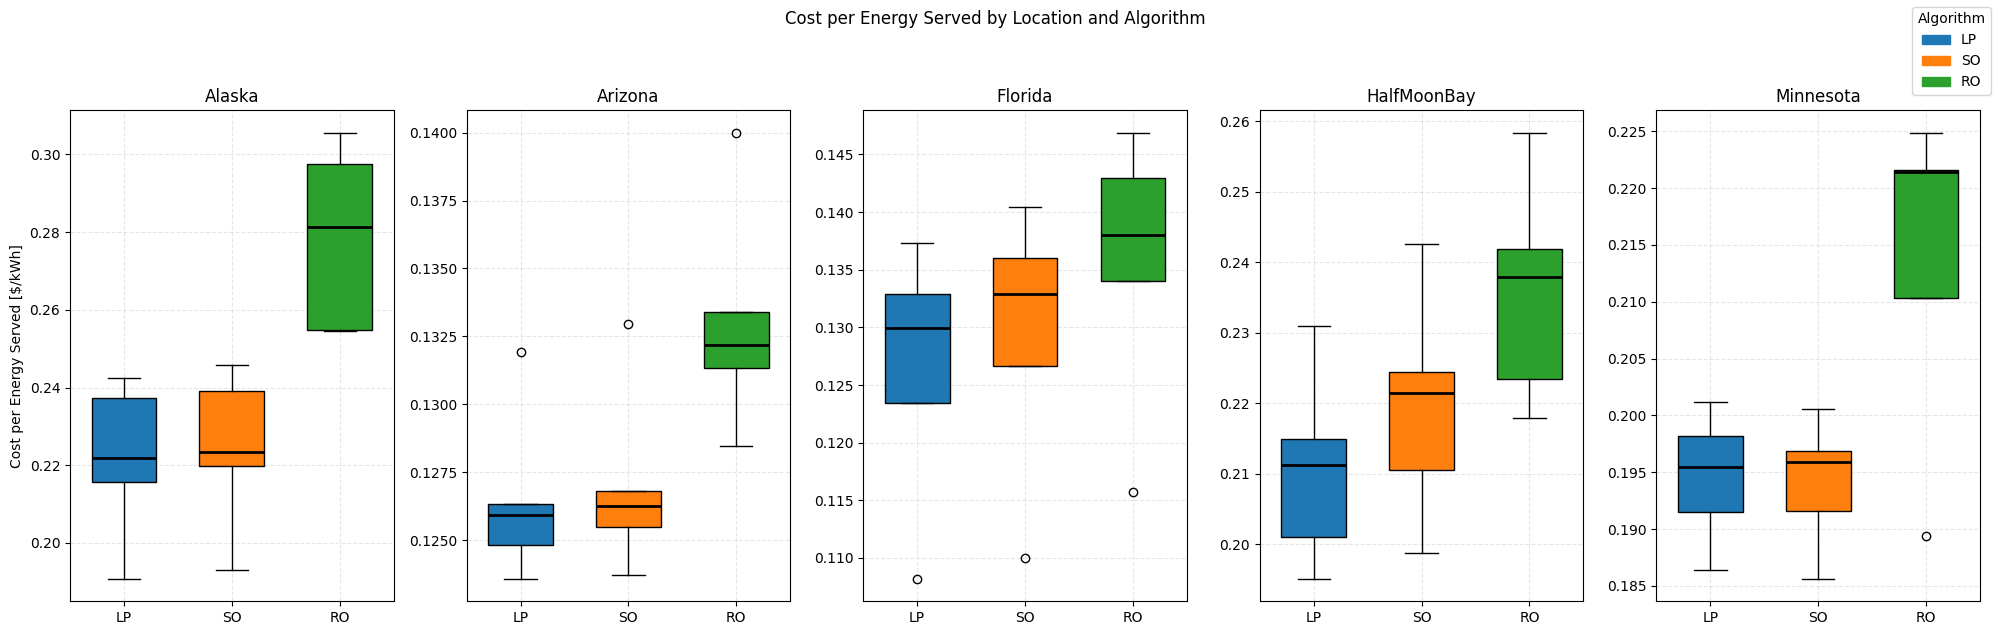

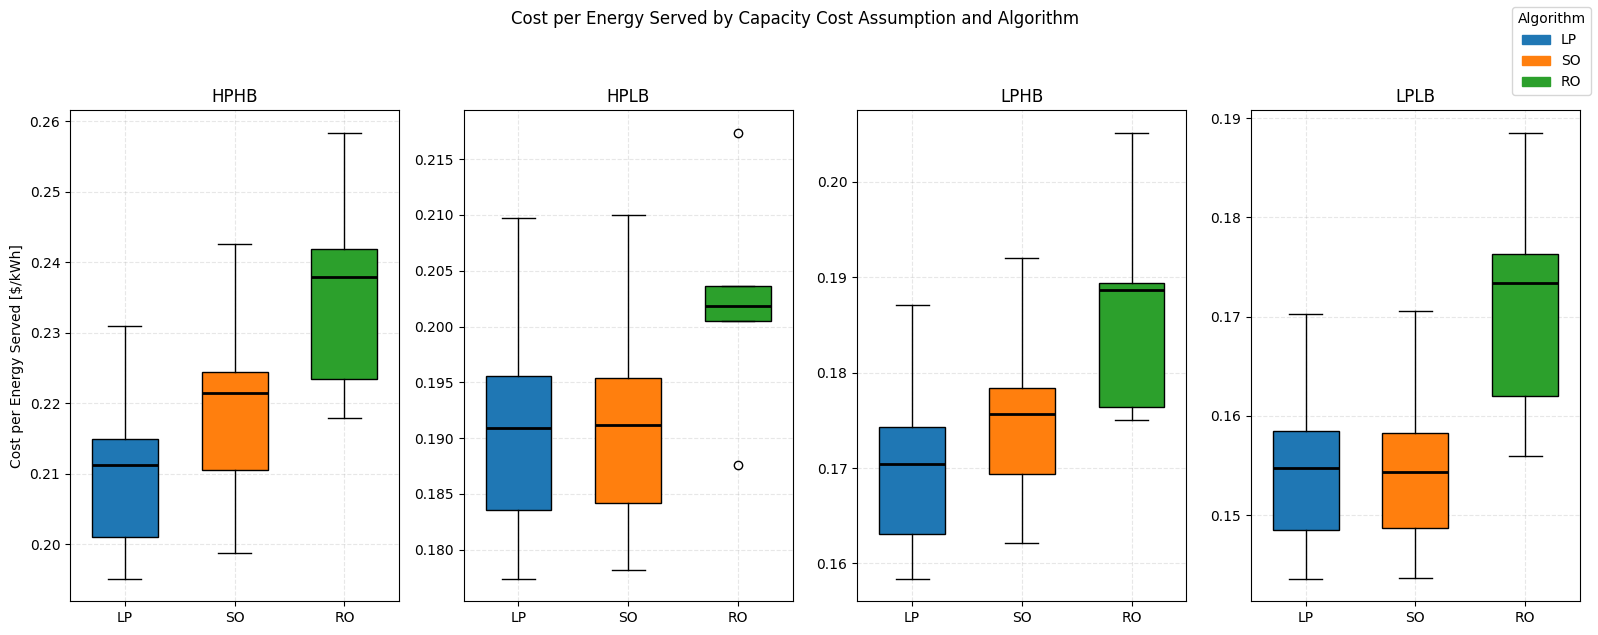

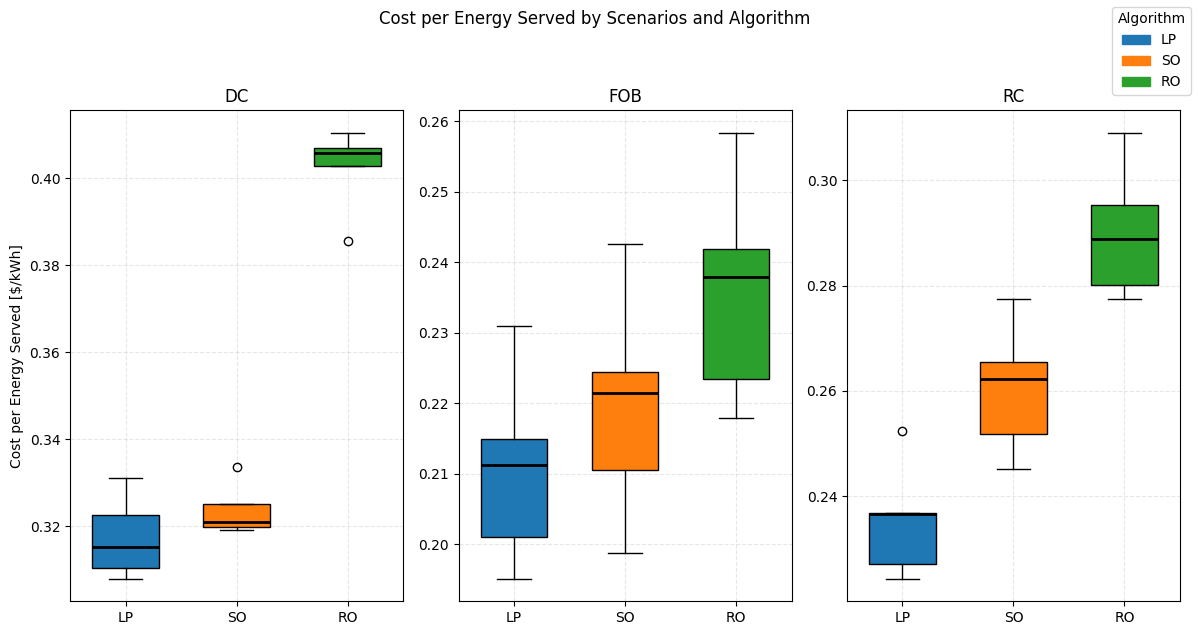

In [71]:

plot_cost_per_energy_boxplots(cost_per_energy_served_loc, 'Location')
plot_cost_per_energy_boxplots(cost_per_energy_served_cap, 'Capacity Cost Assumption')
plot_cost_per_energy_boxplots(cost_per_energy_served_sce, 'Scenarios')